In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader as pdr

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 11.3 MB 162 kB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.3 which is incompatible.


     |████████████████████████████████| 109 kB 8.9 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


# Part2:
In the previous notebook different models and methods were trained. Despite using Neural Networks Architecture the best predictior remained 3 day moving average. 
* In this notebook the new features will be added. New features are:
DowJoe index, S&P500 index, Facebook, Amazon, Apple close prices.
* The Neural Networks "like" small numbers. That is why in this notebook the natural log or the scaled prices will be used

In [ ]:
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2021-09-01')

goo = pdr.get_data_yahoo("GOOG", start, end)
sp = pdr.get_data_yahoo("^GSPC", start, end)
apl = pdr.get_data_yahoo("AAPL", start, end)
fb = pdr.get_data_yahoo("FB", start, end)
amz = pdr.get_data_yahoo("AMZN", start, end)
dj = pdr.get_data_yahoo("^DJI", start, end)

In [ ]:
goo.shape, sp.shape, apl.shape, fb.shape, amz.shape, dj.shape

((2937, 6), (2937, 6), (2937, 6), (2338, 6), (2937, 6), (2937, 6))

## Section 1:
* Prepare data (train/test)
* Preprocess
* Define evaluation metrics and dataset making functions from previous notebook


In [ ]:
# close prices and dates of all except facebook
close_goo = goo['Close'].to_numpy()
close_amz = amz['Close'].to_numpy()
close_sp = sp['Close'].to_numpy()
close_dj = dj['Close'].to_numpy()
close_apl = apl['Close'].to_numpy()
dates = goo.index.to_numpy()

In [ ]:
# Splitting the data
TEST_SIZE = 0.2
n = len(dates)

dates_train = dates[:int(n * (1 - TEST_SIZE))]
goo_train = close_goo[:int(n * (1 - TEST_SIZE))]
amz_train = close_amz[:int(n * (1 - TEST_SIZE))]
sp_train = close_sp[:int(n * (1 - TEST_SIZE))]
dj_train = close_dj[:int(n * (1 - TEST_SIZE))]
apl_train = close_apl[:int(n * (1 - TEST_SIZE))]

dates_test = dates[int(n * (1 - TEST_SIZE)):]
goo_test = close_goo[int(n * (1 - TEST_SIZE)):]
amz_test = close_amz[int(n * (1 - TEST_SIZE)):]
sp_test = close_sp[int(n * (1 - TEST_SIZE)):]
dj_test = close_dj[int(n * (1 - TEST_SIZE)):]
apl_test = close_apl[int(n * (1 - TEST_SIZE)):]

len(dates_train), len(dates_test)

(2349, 588)

In [ ]:
# Define the function for calculating each metric
def model_results(y_true, y_pred):
  # additioanl cast the arguments with float32
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  
  # There are built in functions in tensorflow matrics class
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


  # Mean scaled error
  x = tf.reduce_mean(tf.abs(y_true - y_pred))
  y = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1]))
  mase = (x / y).numpy()

  return {"mae": mae.numpy(), 
          'rmse': rmse.numpy(), 
          "mase": mase}

In [ ]:
# example of window sliding indexing
WINDOW_SIZE = 7
HORIZON = 1
x = np.arange(0, 35)
steps = np.expand_dims(np.arange(WINDOW_SIZE + HORIZON), axis=0)
indexes = steps + (np.expand_dims(np.arange(len(x) - (WINDOW_SIZE + HORIZON - 1)), axis=0)).T
indexes

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [ 9, 10, 11, 12, 13, 14, 15, 16],
       [10, 11, 12, 13, 14, 15, 16, 17],
       [11, 12, 13, 14, 15, 16, 17, 18],
       [12, 13, 14, 15, 16, 17, 18, 19],
       [13, 14, 15, 16, 17, 18, 19, 20],
       [14, 15, 16, 17, 18, 19, 20, 21],
       [15, 16, 17, 18, 19, 20, 21, 22],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [17, 18, 19, 20, 21, 22, 23, 24],
       [18, 19, 20, 21, 22, 23, 24, 25],
       [19, 20, 21, 22, 23, 24, 25, 26],
       [20, 21, 22, 23, 24, 25, 26, 27],
       [21, 22, 23, 24, 25, 26, 27, 28],
       [22, 23, 24, 25, 26, 27, 28, 29],
       [23, 24, 25, 26, 27, 28, 29, 30],
       [24, 25, 

In [ ]:
# defining the function which will create dataset
# additional for new stocks 
def dataset_from_timeseries(x, window_size, horizon):
  cols = []
  for i in range(window_size):
    cols.append(f'x_{i}')
  cols.append('y')
  # Create one row of steps as nested array
  window_steps = np.expand_dims(np.arange(window_size + horizon), axis=0)
  # Create transposed matrix of indexes
  indexes = window_steps + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
  # Creating pandas dataframe with indexes of x then putting columns
  df = pd.DataFrame(x[indexes])
  df.columns = cols
  return df


In [ ]:
# Creating the dataset from google stocks
WINDOW_SIZE = 7
HORIZON = 1
train_dataset = dataset_from_timeseries(x=goo_train, 
                                        window_size=WINDOW_SIZE,
                                        horizon=HORIZON)
test_dataset = dataset_from_timeseries(x=goo_test,
                                       window_size=WINDOW_SIZE,
                                       horizon=HORIZON)
train_dataset.shape, test_dataset.shape

((2342, 8), (581, 8))

In [ ]:
# adding new columns
train_dataset['s_p'] = sp_train[WINDOW_SIZE:]
train_dataset['amz'] = amz_train[WINDOW_SIZE:]
train_dataset['dj'] = dj_train[WINDOW_SIZE:]
train_dataset['apl'] = apl_train[WINDOW_SIZE:]

test_dataset['s_p'] = sp_test[WINDOW_SIZE:]
test_dataset['amz'] = amz_test[WINDOW_SIZE:]
test_dataset['dj'] = dj_test[WINDOW_SIZE:]
test_dataset['apl'] = apl_test[WINDOW_SIZE:]

In [ ]:
train_dataset

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,y,s_p,amz,dj,apl
0,312.204773,310.829926,302.994293,295.940735,299.885956,299.432648,294.137512,292.448822,1145.680054,129.110001,10680.769531,7.523214
1,310.829926,302.994293,295.940735,299.885956,299.432648,294.137512,292.448822,293.823669,1148.459961,127.349998,10710.549805,7.479643
2,302.994293,295.940735,299.885956,299.432648,294.137512,292.448822,293.823669,288.917053,1136.030029,127.139999,10609.650391,7.354643
3,295.940735,299.885956,299.432648,294.137512,292.448822,293.823669,288.917053,292.712830,1150.229980,127.610001,10725.429688,7.680000
4,299.885956,299.432648,294.137512,292.448822,293.823669,288.917053,292.712830,289.121307,1138.040039,125.779999,10603.150391,7.561786
...,...,...,...,...,...,...,...,...,...,...,...,...
2337,1236.339966,1236.369995,1248.839966,1264.550049,1256.000000,1263.449951,1272.180054,1287.579956,2943.030029,1938.430054,26554.390625,51.152500
2338,1236.369995,1248.839966,1264.550049,1256.000000,1263.449951,1272.180054,1287.579956,1188.479980,2945.830078,1926.520020,26592.910156,50.167500
2339,1248.839966,1264.550049,1256.000000,1263.449951,1272.180054,1287.579956,1188.479980,1168.079956,2923.729980,1911.520020,26430.140625,52.630001
2340,1264.550049,1256.000000,1263.449951,1272.180054,1287.579956,1188.479980,1168.079956,1162.609985,2917.520020,1900.819946,26307.789062,52.287498


In [ ]:
# Creating train test datasets
# Natural log of values will be used
cols = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 's_p', 'amz', 'dj', 'apl']
x_train = np.log(train_dataset[cols]).to_numpy()
y_train = np.log(train_dataset.y).to_numpy()

x_test = np.log(test_dataset[cols]).to_numpy()
y_test = np.log(test_dataset.y).to_numpy()

x_train.shape, x_test.shape

((2342, 11), (581, 11))

In [ ]:
import os 

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

### Moving average:
In the previous notebook the best predictor was 3 day moving average

In [ ]:
# using the 3 days moving average in logarithmic data
# define the function which will take window size of the previous prices and predicts the next day's price with average of chosen values
def moving_average_window(x, window_size):
  x = pd.Series(x)
  return x.rolling(window_size).mean()

In [ ]:

len(dates_test) , len(y_pred)

(588, 581)

Moving average results and plot: 
 {'mae': 0.00923504, 'rmse': 0.01325588, 'mase': 0.5970466}


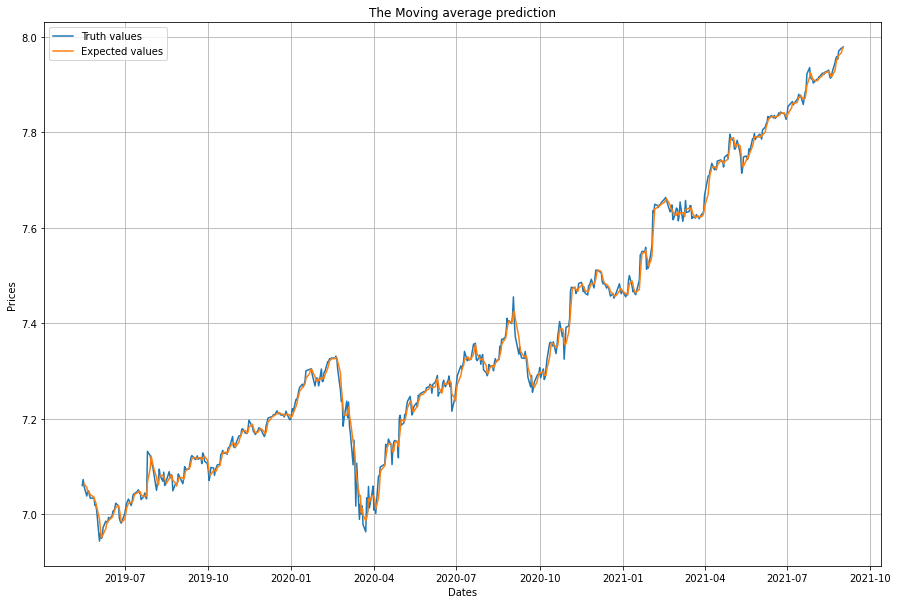

In [ ]:
y_pred = moving_average_window(y_test, 3)
y_pred_tmp = y_pred[2:]
y_test_tmp = y_test[2:]
model1_maw = model_results(y_true=y_test_tmp,
                           y_pred=y_pred_tmp)
print(f"Moving average results and plot: \n {model1_maw}")
plt.figure(figsize=(15, 10))
sns.lineplot(x=dates_test[7:], y=y_test, label='Truth values')
sns.lineplot(x=dates_test[7:], y=y_pred, label='Expected values')
plt.title("The Moving average prediction")
plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

### Simple Dense Model

In [ ]:
BATCH_SIZE = 64
INPUT_SHAPE = x_train.shape[1]
inputs = tf.keras.Input(shape=(INPUT_SHAPE, ), name='input_layer')
x = tf.keras.layers.Dense(128, activation='relu', name='dense_layer1')(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model2 = tf.keras.Model(inputs, outputs, name='model2_dense')

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=['mae'])
model2.summary()

Model: "model2_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 11)]              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 128)               1536      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist2 = model2.fit(x_train, 
                   y_train, 
                   verbose=0,
                   epochs=100,
                   batch_size=BATCH_SIZE,
                   validation_data=(x_test, y_test),
                   validation_steps=10)

In [ ]:
y_pred = model2.predict(x_test)

In [ ]:
len(y_pred), len(dates_test[WINDOW_SIZE:])

(581, 581)

{'mae': 0.030872703, 'rmse': 0.038635563, 'mase': 0.9802047}


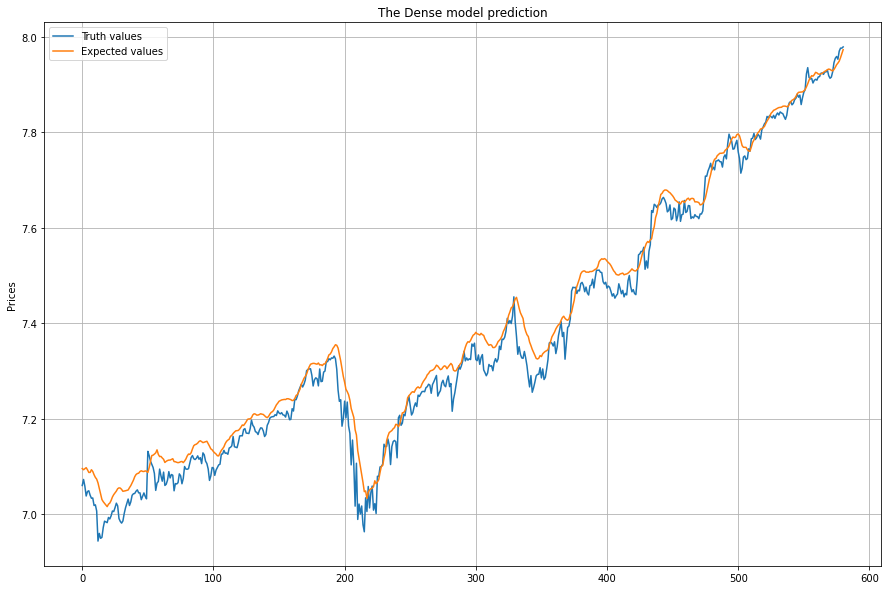

In [ ]:
model2_res = model_results(y_test, tf.squeeze(y_pred))
print(model2_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

### Conv1D

In [ ]:
expanding_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), name='expand_layer')

inputs = tf.keras.Input(shape=(INPUT_SHAPE, ), name='input_layer')
x = expanding_layer(inputs)
x = tf.keras.layers.Conv1D(128, kernel_size=WINDOW_SIZE,
                           strides=1, padding='causal',
                           activation='linear', name='conv1d_layer')(x)

x = tf.keras.layers.Flatten(name='flatten_layer')(x)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model5 = tf.keras.Model(inputs, outputs, name='model5_dense')

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               )
model5.summary()

Model: "model5_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 11)]              0         
_________________________________________________________________
expand_layer (Lambda)        (None, 1, 11)             0         
_________________________________________________________________
conv1d_layer (Conv1D)        (None, 1, 128)            9984      
_________________________________________________________________
flatten_layer (Flatten)      (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5.fit(x_train, 
           y_train,
           epochs=100,
           verbose=0,
           validation_data=(x_test, y_test),
           validation_steps=int(0.5 * len(y_test)),
           callbacks=[create_model_checkpoint(model_name="con1d_1layer")])

INFO:tensorflow:Assets written to: model_experiments/con1d_1layer/assets


In [ ]:
model5 = tf.keras.models.load_model("model_experiments/con1d_1layer")
y_pred = model5.predict(x_test)

{'mae': 0.32144237, 'rmse': 0.40039566, 'mase': 0.9998487}


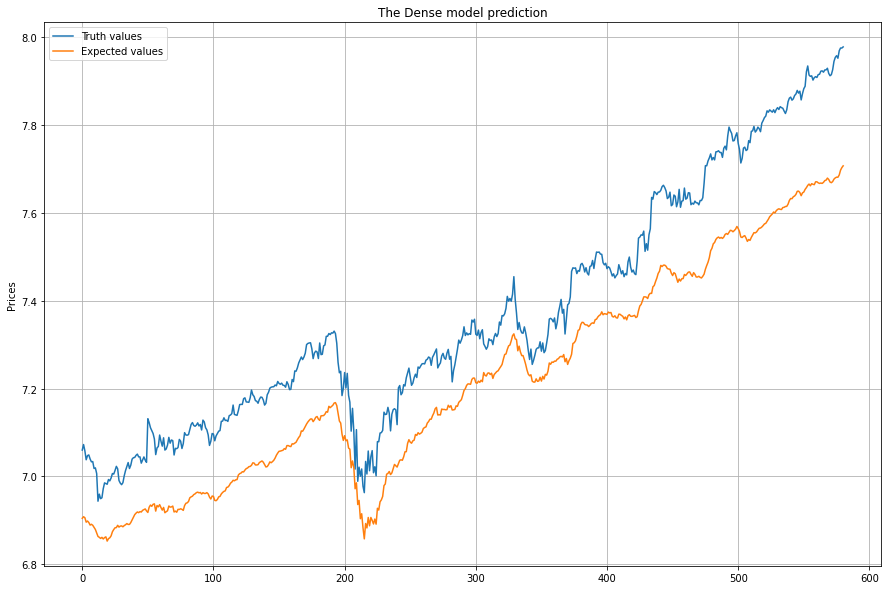

In [ ]:
model5_res = model_results(y_test, y_pred)
print(model5_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

### Paralellized Conv1D layer blocks (like Inception in Computer Vision)

In [ ]:
inputs = tf.keras.Input(shape=(INPUT_SHAPE), name='input_layer')
x = expanding_layer(inputs)

#####
conv1 = tf.keras.layers.Conv1D(64, kernel_size=7, strides=1,
                               padding='causal', activation='relu', name='conv1_block1')(x)
#####
conv2 = tf.keras.layers.Conv1D(64, kernel_size=5, strides=1,
                               padding='causal', activation='relu', name='conv2_block1')(x)
#####
conv3 = tf.keras.layers.Conv1D(64, kernel_size=3, strides=1,
                               padding='causal', activation='relu', name='conv3_block1')(x)
#####
pool = tf.keras.layers.MaxPool1D(pool_size=3, padding='same', name='pool_block1')(x)
conv4 = tf.keras.layers.Conv1D(64, kernel_size=9, strides=1,
                               padding='causal', activation='relu', name='conv4_block1')(pool)

####
concat = tf.keras.layers.concatenate([conv1, conv2, conv3, conv4], axis=-1, name='concat_layer')
x = tf.keras.layers.Flatten(name='flatten_layer')(concat)
x = tf.keras.layers.Dense(128, activation=None, name='dense_1')(x)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model6 = tf.keras.Model(inputs, outputs, name='inception_1_block')

model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.MeanAbsoluteError())
model6.summary()


Model: "inception_1_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 11)]         0                                            
__________________________________________________________________________________________________
expand_layer (Lambda)           (None, 1, 11)        0           input_layer[0][0]                
__________________________________________________________________________________________________
pool_block1 (MaxPooling1D)      (None, 1, 11)        0           expand_layer[3][0]               
__________________________________________________________________________________________________
conv1_block1 (Conv1D)           (None, 1, 64)        4992        expand_layer[3][0]               
__________________________________________________________________________________

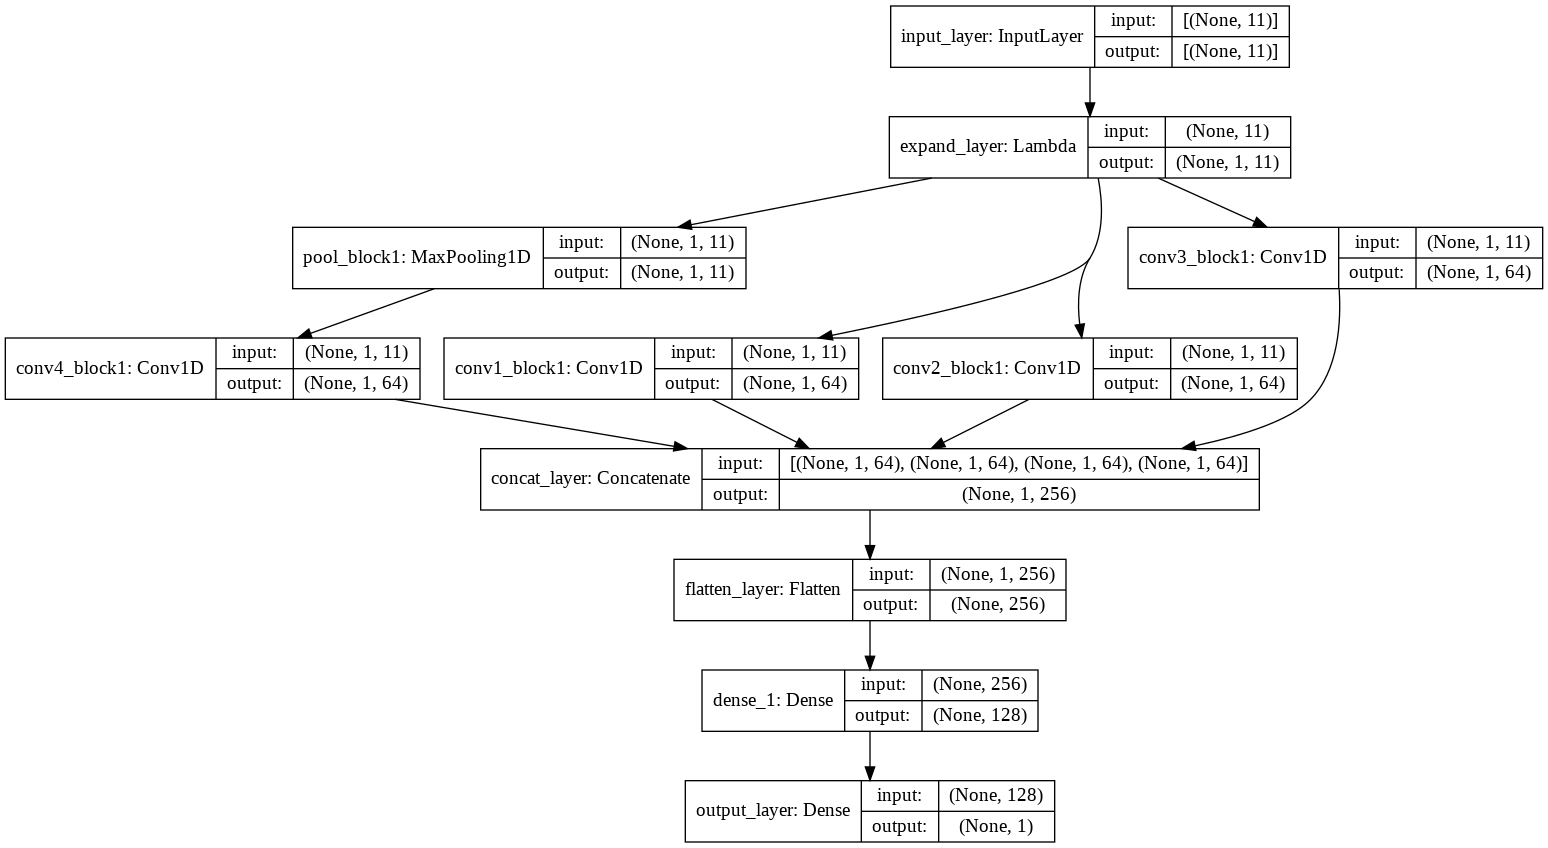

In [ ]:
tf.keras.utils.plot_model(model6, show_shapes=True)

In [ ]:
model6.fit(x_train, 
           y_train,
           epochs=100,
           verbose=1,
           validation_data=(x_test, y_test),
           validation_steps=int(0.5 * len(y_test)),
           callbacks=[create_model_checkpoint(model_name="incep_1block")])

Epoch 1/100
74/74 [==============================] - 1s 9ms/step - loss: 1.1318 - val_loss: 0.0542
INFO:tensorflow:Assets written to: model_experiments/incep_1block/assets
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0415
Epoch 3/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0302
Epoch 4/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0260
Epoch 5/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 6/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 7/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 8/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 9/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 10/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 11/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0298
Epoch 12/100
74/74 [======

In [ ]:
model6 = tf.keras.models.load_model("model_experiments/incep_1block")
y_pred = model6.predict(x_test)

{'mae': 0.3032039, 'rmse': 0.3790512, 'mase': 1.0009031}


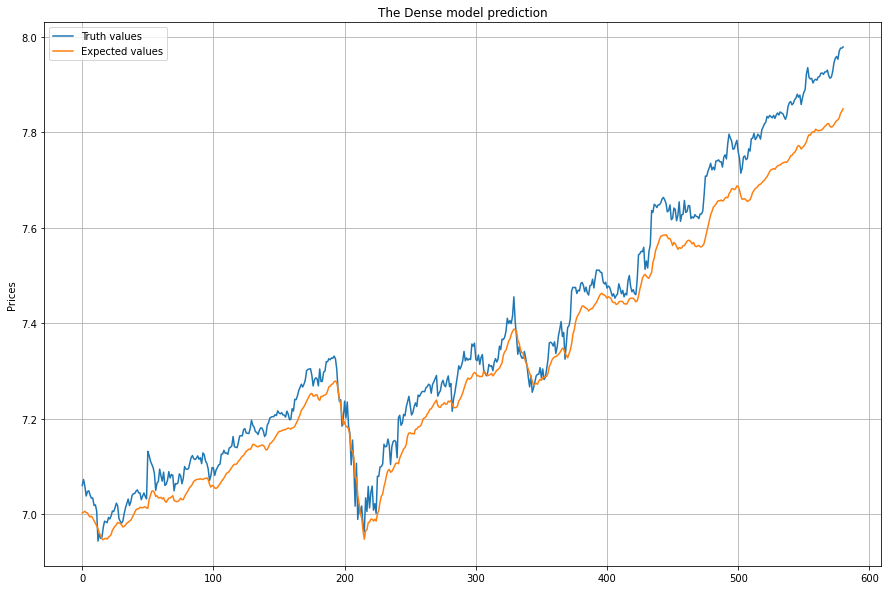

In [ ]:
model6_res = model_results(y_test, y_pred)
print(model6_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

## Section 2:
Same in MinMax scaled data. As a result we got a structured cross sectional data, and scaler for each column can be used

In [ ]:
train_max = train_dataset.max(axis=0).to_numpy()
train_min = train_dataset.min(axis=0).to_numpy()


x_train = (train_dataset - train_min) / (train_max - train_min)
x_test = (test_dataset - train_min) / (train_max - train_min)

y_train = x_train.y.to_numpy()
x_train = x_train[cols].to_numpy()

y_test = x_test.y.to_numpy()
x_test = x_test[cols].to_numpy()

x_test = np.clip(x_test, 0, 1)
y_test = np.clip(y_test, 0, 1)

In [ ]:
inputs = tf.keras.Input(shape=(INPUT_SHAPE), name='input_layer')
x = expanding_layer(inputs)

#####
conv1 = tf.keras.layers.Conv1D(32, kernel_size=7, strides=1,
                               padding='causal', activation='relu', name='conv1_block1')(x)
#####
conv2 = tf.keras.layers.Conv1D(64, kernel_size=5, strides=1,
                               padding='causal', activation='relu', name='conv2_block1')(x)
#####
conv3 = tf.keras.layers.Conv1D(64, kernel_size=3, strides=1,
                               padding='causal', activation='relu', name='conv3_block1')(x)
#####
pool = tf.keras.layers.MaxPool1D(pool_size=3, padding='same', name='pool_block1')(x)
conv4 = tf.keras.layers.Conv1D(32, kernel_size=9, strides=1,
                               padding='causal', activation='relu', name='conv4_block1')(pool)

####
concat = tf.keras.layers.concatenate([conv1, conv2, conv3, conv4], axis=-1, name='concat_layer')
x = tf.keras.layers.Flatten(name='flatten_layer')(concat)
x = tf.keras.layers.Dropout(0.4, name='dropout_layer')(x)
x = tf.keras.layers.Dense(128, activation='sigmoid', name='dense_1')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(x)

model6 = tf.keras.Model(inputs, outputs, name='inception_1_block')

model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=['mae'])
model6.summary()


Model: "inception_1_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 11)]         0                                            
__________________________________________________________________________________________________
expand_layer (Lambda)           (None, 1, 11)        0           input_layer[0][0]                
__________________________________________________________________________________________________
pool_block1 (MaxPooling1D)      (None, 1, 11)        0           expand_layer[7][0]               
__________________________________________________________________________________________________
conv1_block1 (Conv1D)           (None, 1, 32)        2496        expand_layer[7][0]               
__________________________________________________________________________________

In [ ]:
model6.fit(x_train, 
           y_train,
           epochs=100,
           verbose=1,
           validation_data=(x_test, y_test),
           validation_steps=int(0.5 * len(y_test)),
           callbacks=[create_model_checkpoint(model_name="incep_1block_2")])

Epoch 1/100
74/74 [==============================] - 1s 9ms/step - loss: 0.2325 - mae: 0.2325 - val_loss: 0.4299 - val_mae: 0.4299
INFO:tensorflow:Assets written to: model_experiments/incep_1block_2/assets
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 0.1805 - mae: 0.1805
Epoch 3/100
74/74 [==============================] - 0s 3ms/step - loss: 0.1232 - mae: 0.1232
Epoch 4/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0721 - mae: 0.0721
Epoch 5/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0453 - mae: 0.0453
Epoch 6/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0366 - mae: 0.0366
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0345 - mae: 0.0345
Epoch 8/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0331 - mae: 0.0331
Epoch 9/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0312 - mae: 0.0312
Epoch 10/100
74/74 [======================

{'mae': 0.4299173, 'rmse': 0.43356833, 'mase': 0.99962974}


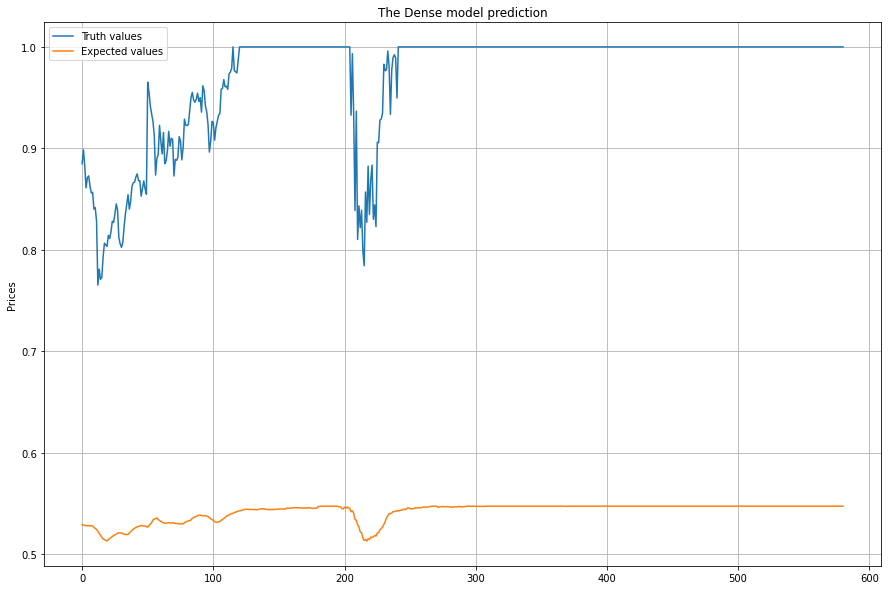

In [ ]:
model6 = tf.keras.models.load_model("model_experiments/incep_1block_2")
y_pred = model6.predict(x_test)
model6_res = model_results(y_test, y_pred)
print(model6_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

 Clipping was not good idea

In [ ]:
train_max = train_dataset.max(axis=0).to_numpy()
train_min = train_dataset.min(axis=0).to_numpy()


x_train = (train_dataset - train_min) / (train_max - train_min)
x_test = (test_dataset - train_min) / (train_max - train_min)

y_train = x_train.y.to_numpy()
x_train = x_train[cols].to_numpy()

y_test = x_test.y.to_numpy()
x_test = x_test[cols].to_numpy()

In [ ]:
inputs = tf.keras.Input(shape=(INPUT_SHAPE), name='input_layer')
x = expanding_layer(inputs)

#####
conv1 = tf.keras.layers.Conv1D(32, kernel_size=7, strides=1,
                               padding='causal', activation='relu', name='conv1_block1')(x)
#####
conv2 = tf.keras.layers.Conv1D(64, kernel_size=5, strides=1,
                               padding='causal', activation='relu', name='conv2_block1')(x)
#####
conv3 = tf.keras.layers.Conv1D(128, kernel_size=3, strides=1,
                               padding='causal', activation='relu', name='conv3_block1')(x)
#####
pool = tf.keras.layers.MaxPool1D(pool_size=3, padding='same', name='pool_block1')(x)
conv4 = tf.keras.layers.Conv1D(32, kernel_size=11, strides=1,
                               padding='causal', activation='relu', name='conv4_block1')(pool)

####
concat = tf.keras.layers.concatenate([conv1, conv2, conv3, conv4], axis=-1, name='concat_layer')
x = tf.keras.layers.Flatten(name='flatten_layer')(concat)
x = tf.keras.layers.Dropout(0.5, name='dropout_layer')(x)
x = tf.keras.layers.Dense(256, activation='linear', name='dense_1')(x)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model6 = tf.keras.Model(inputs, outputs, name='inception_1_block')

model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=['mae'])
model6.summary()


Model: "inception_1_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 11)]         0                                            
__________________________________________________________________________________________________
expand_layer (Lambda)           (None, 1, 11)        0           input_layer[0][0]                
__________________________________________________________________________________________________
pool_block1 (MaxPooling1D)      (None, 1, 11)        0           expand_layer[9][0]               
__________________________________________________________________________________________________
conv1_block1 (Conv1D)           (None, 1, 32)        2496        expand_layer[9][0]               
__________________________________________________________________________________

{'mae': 0.48098436, 'rmse': 0.6272379, 'mase': 1.0017536}


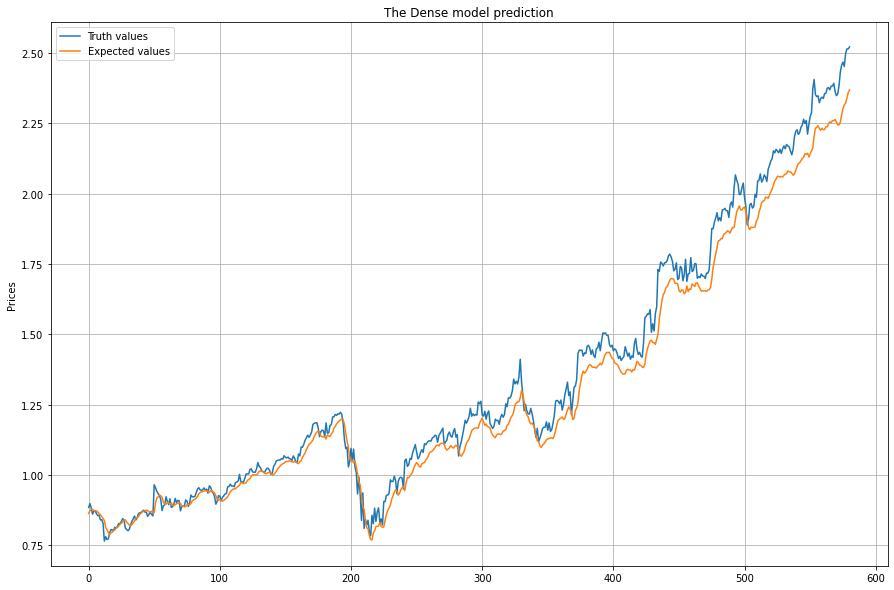

In [ ]:
model6.fit(x_train, 
           y_train,
           epochs=100,
           batch_size=128
           verbose=0,
           validation_data=(x_test, y_test),
           validation_steps=int(0.5 * len(y_test))
           )

y_pred = model6.predict(x_test)
model6_res = model_results(y_test, y_pred)
print(model6_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

### Model with Inception block with 2 branches of input
* Input 1: Window_sized row of Google stock prices
* Input 2: Close prices of the same day for S&P, DJ, AAPL, AMZN

In [ ]:
def inception_block(inputs, c1, c2, c3, c4, block_n):
  """
  Function creates Inception blocks with Functional API
  Arguments:
  c1: number of filters for 7x7 layer
  c2: number of filters for 5x5 layer
  c3: number of filters for 3x3 layer
  c4: number of filters for ws x ws layer
  block_n: name of the block
  """
  ##### 7x7
  conv1 = tf.keras.layers.Conv1D(c1, kernel_size=7, strides=1,
                                padding='causal', activation='relu', name=f'conv1_{block_n}')(inputs)
  ##### 5x5
  conv2 = tf.keras.layers.Conv1D(c2, kernel_size=5, strides=1,
                                padding='causal', activation='relu', name=f'conv2_{block_n}')(inputs)
  ##### 3x3
  conv3 = tf.keras.layers.Conv1D(c3, kernel_size=3, strides=1,
                                padding='causal', activation='relu', name=f'conv3_{block_n}')(inputs)
  ##### ws x ws pooling layer
  pool = tf.keras.layers.MaxPool1D(pool_size=3, padding='same', name=f'pool_{block_n}')(inputs)
  conv4 = tf.keras.layers.Conv1D(c4, kernel_size=inputs.shape[-1], strides=1,
                                padding='causal', activation='relu', name=f'conv4_{block_n}')(pool)

  ####
  concat = tf.keras.layers.concatenate([conv1, conv2, conv3, conv4], axis=-1, name=f'concat_layer_{block_n}')
  return concat


In [ ]:
inputs1 = tf.keras.Input(shape=(WINDOW_SIZE, ), name='goo_input_layer')
inputs2 = tf.keras.Input(shape=(INPUT_SHAPE - WINDOW_SIZE, ), name='st_input_layer')

##### The Block for Google close prices
# expand
x1 = expanding_layer(inputs1)
# block 1
block1 = inception_block(inputs=x1,
                         c1=64,
                         c2=128,
                         c3=128,
                         c4=64,
                         block_n='goo_inception_block1')
#print(block1.shape)

##### Conv1 layer for other stocks
x2 = tf.keras.layers.Dense(256, activation='relu', name='st_dense1_layer')(inputs2)
x2 = tf.expand_dims(x2, axis=1)
# print(x2.shape)

##### Concat
concat = tf.keras.layers.concatenate([block1, x2], axis=-1, name='concat_layer')

x = tf.keras.layers.Flatten(name='flatten_layer')(concat)
x = tf.keras.layers.Dropout(0.5, name='dropout_layer')(x)
x = tf.keras.layers.Dense(256, activation='linear', name='combined_dense_layer1')(x)
x = tf.keras.layers.BatchNormalization(name='batchnorm_layer')(x)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model7 = tf.keras.Model(inputs=[inputs1, inputs2],
                        outputs=outputs, name='multi_input_model')

model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()]
               )
model7.summary()

Model: "multi_input_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
goo_input_layer (InputLayer)    [(None, 7)]          0                                            
__________________________________________________________________________________________________
expand_layer (Lambda)           multiple             0           goo_input_layer[0][0]            
__________________________________________________________________________________________________
pool_goo_inception_block1 (MaxP (None, 1, 7)         0           expand_layer[19][0]              
__________________________________________________________________________________________________
st_input_layer (InputLayer)     [(None, 4)]          0                                            
__________________________________________________________________________________

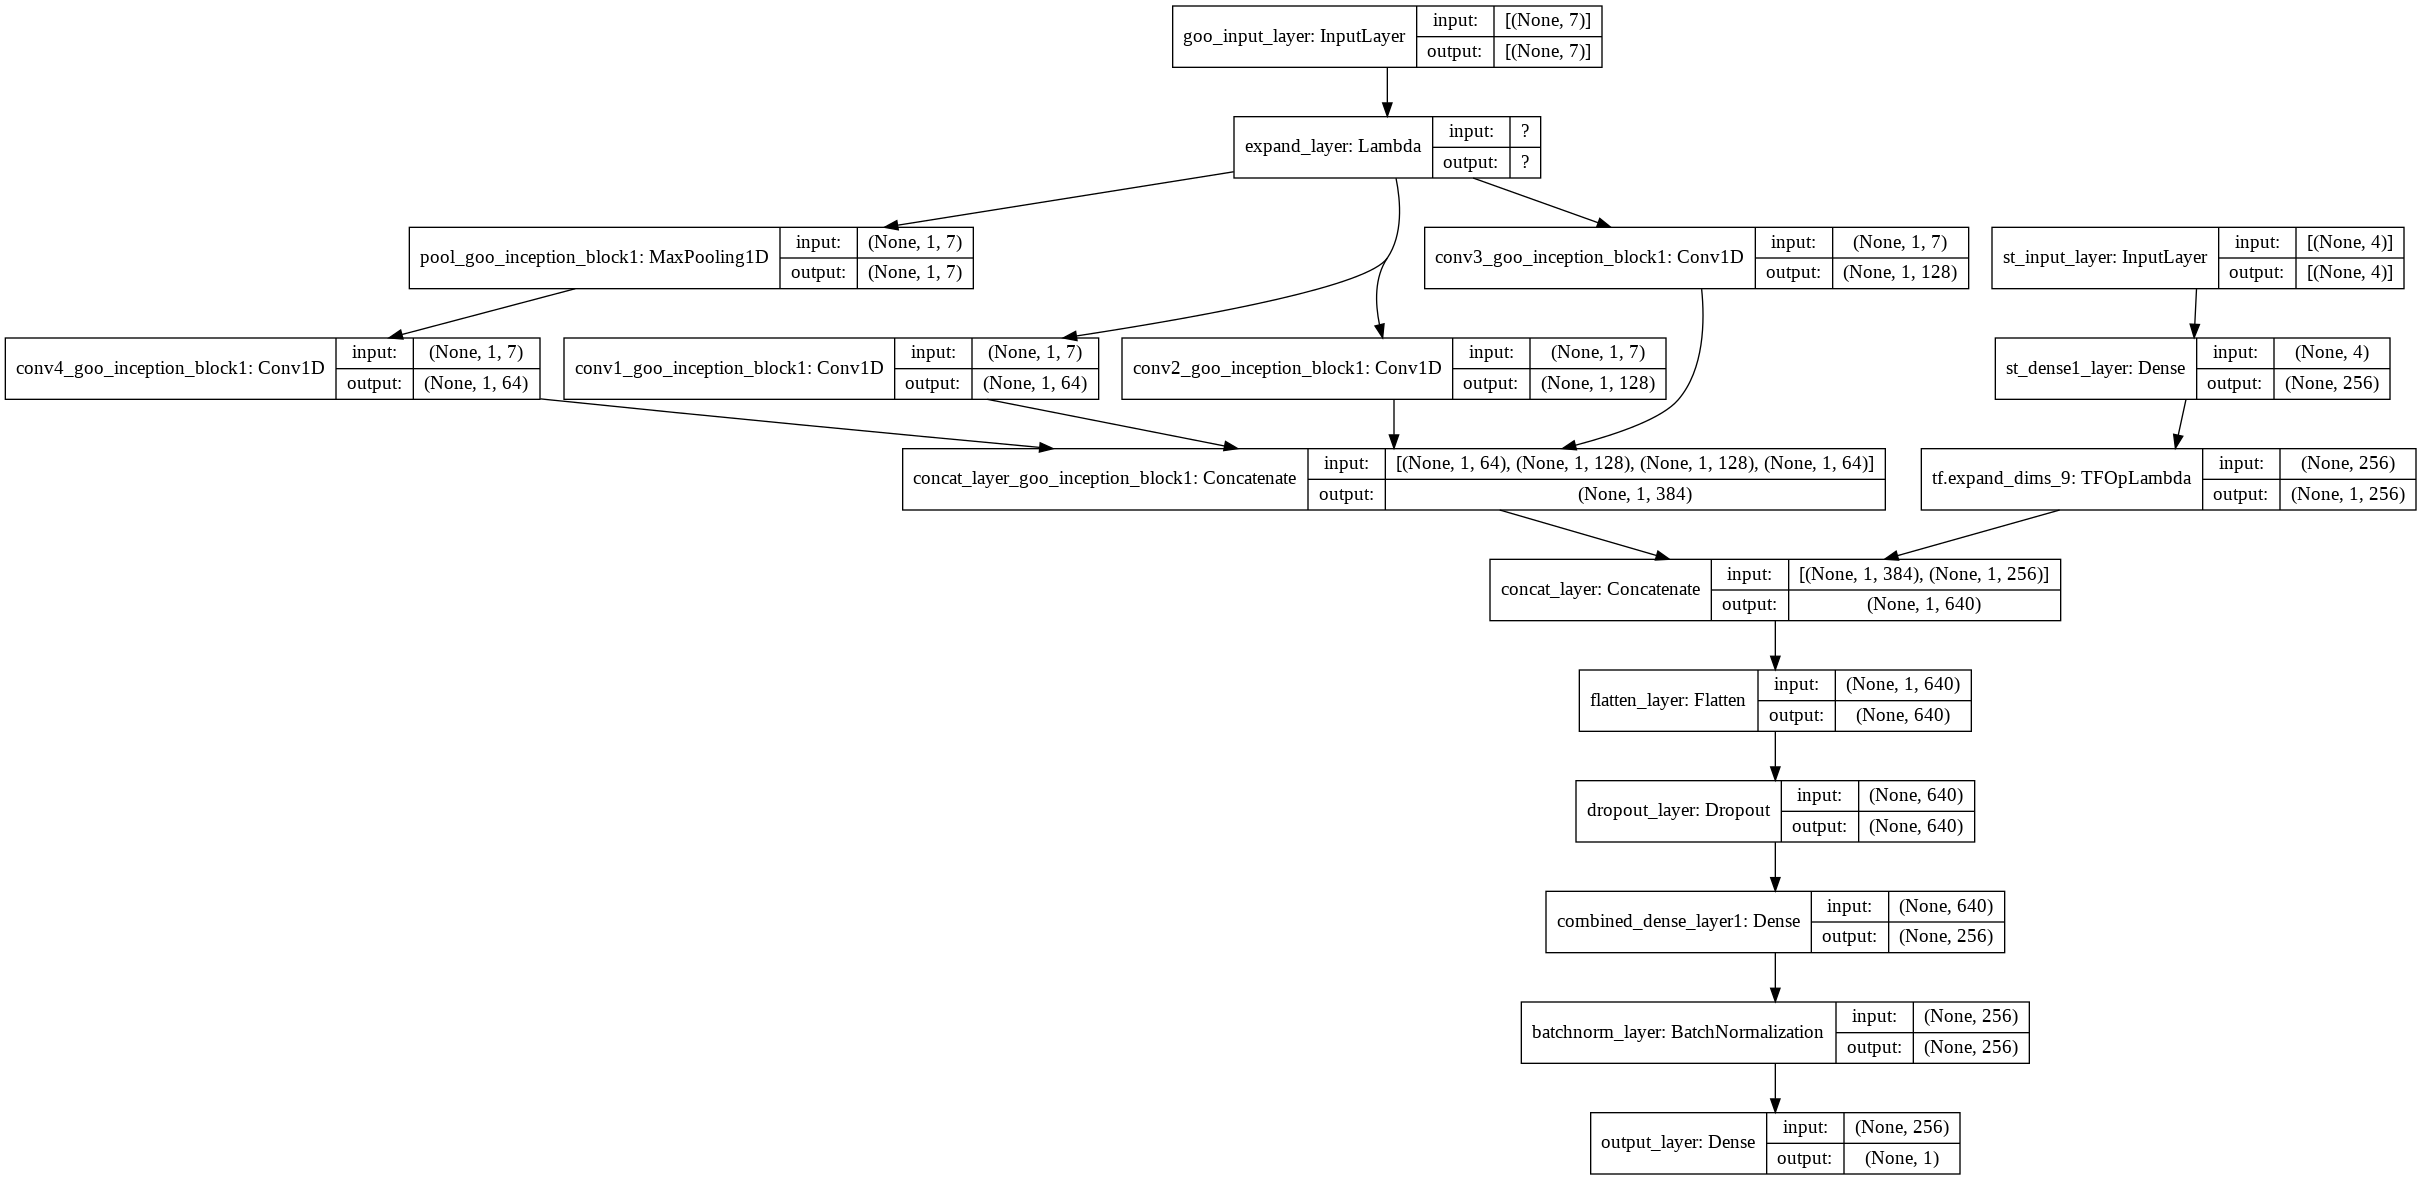

In [ ]:
tf.keras.utils.plot_model(model7, show_shapes=True)

{'mae': 0.4883403, 'rmse': 0.6346071, 'mase': 1.002259}


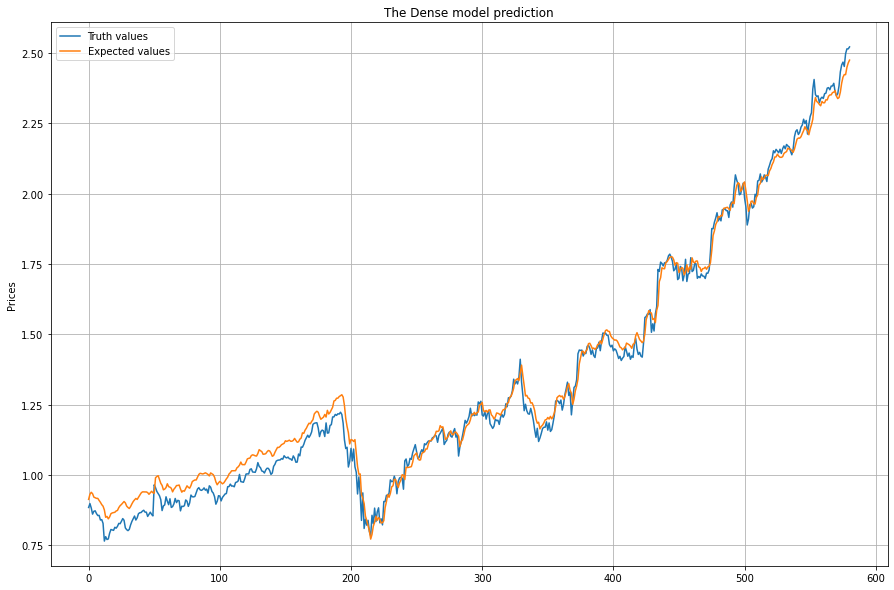

In [ ]:
model7.fit([x_train[:, :7], x_train[:, 7:]], 
           y_train,
           epochs=300,
           batch_size=128,
           verbose=0,
           validation_data=([x_test[:, :7], x_test[:, 7:]], y_test),
           validation_steps=int(0.5 * len(y_test))
           )

y_pred = model7.predict([x_test[:, :7], x_test[:, 7:]])
model7_res = model_results(y_test, y_pred)
print(model7_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

### Inception and ResNet blocks

In [ ]:
inputs1 = tf.keras.Input(shape=(WINDOW_SIZE, ), name='goo_input_layer')
inputs2 = tf.keras.Input(shape=(INPUT_SHAPE - WINDOW_SIZE, ), name='st_input_layer')

##### The Block for Google close prices
# expand
x1 = expanding_layer(inputs1)
# block 1
block1 = inception_block(inputs=x1,
                         c1=32,
                         c2=64,
                         c3=128,
                         c4=32,
                         block_n='goo_inception_block1')

block2 = inception_block(inputs=block1,
                         c1=64,
                         c2=128,
                         c3=128,
                         c4=64,
                         block_n='goo_inception_block2')
# Resnet part
# Making inputs with same filters size for resnet trick
inputs_res = tf.keras.layers.Conv1D(filters=64+128+128+64, kernel_size=3, 
                                    strides=1, padding='causal', activation='relu',
                                    name='input_expanding_layer')(x1)
# adding block and expanded layer
block_res = tf.keras.layers.add([block2, inputs_res], name='add_layer')                                  

#print(block1.shape)

##### Conv1 layer for other stocks
x2 = tf.keras.layers.Dense(256, activation='relu', name='st_dense1_layer')(inputs2)
x2 = tf.expand_dims(x2, axis=1)
# # print(x2.shape)

# ##### Concat
concat = tf.keras.layers.concatenate([block_res, x2], axis=-1, name='concat_layer')

x = tf.keras.layers.Flatten(name='flatten_layer')(concat)
x = tf.keras.layers.Dropout(0.5, name='dropout_layer')(x)
x = tf.keras.layers.Dense(256, activation='linear', name='combined_dense_layer1')(x)
x = tf.keras.layers.BatchNormalization(name='batchnorm_layer')(x)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model8 = tf.keras.Model(inputs=[inputs1, inputs2],
                        outputs=outputs, name='multi_res_input_model')

model8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()]
               )
model8.summary()

Model: "multi_res_input_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
goo_input_layer (InputLayer)    [(None, 7)]          0                                            
__________________________________________________________________________________________________
expand_layer (Lambda)           multiple             0           goo_input_layer[0][0]            
__________________________________________________________________________________________________
pool_goo_inception_block1 (MaxP (None, 1, 7)         0           expand_layer[21][0]              
__________________________________________________________________________________________________
conv1_goo_inception_block1 (Con (None, 1, 32)        1600        expand_layer[21][0]              
______________________________________________________________________________

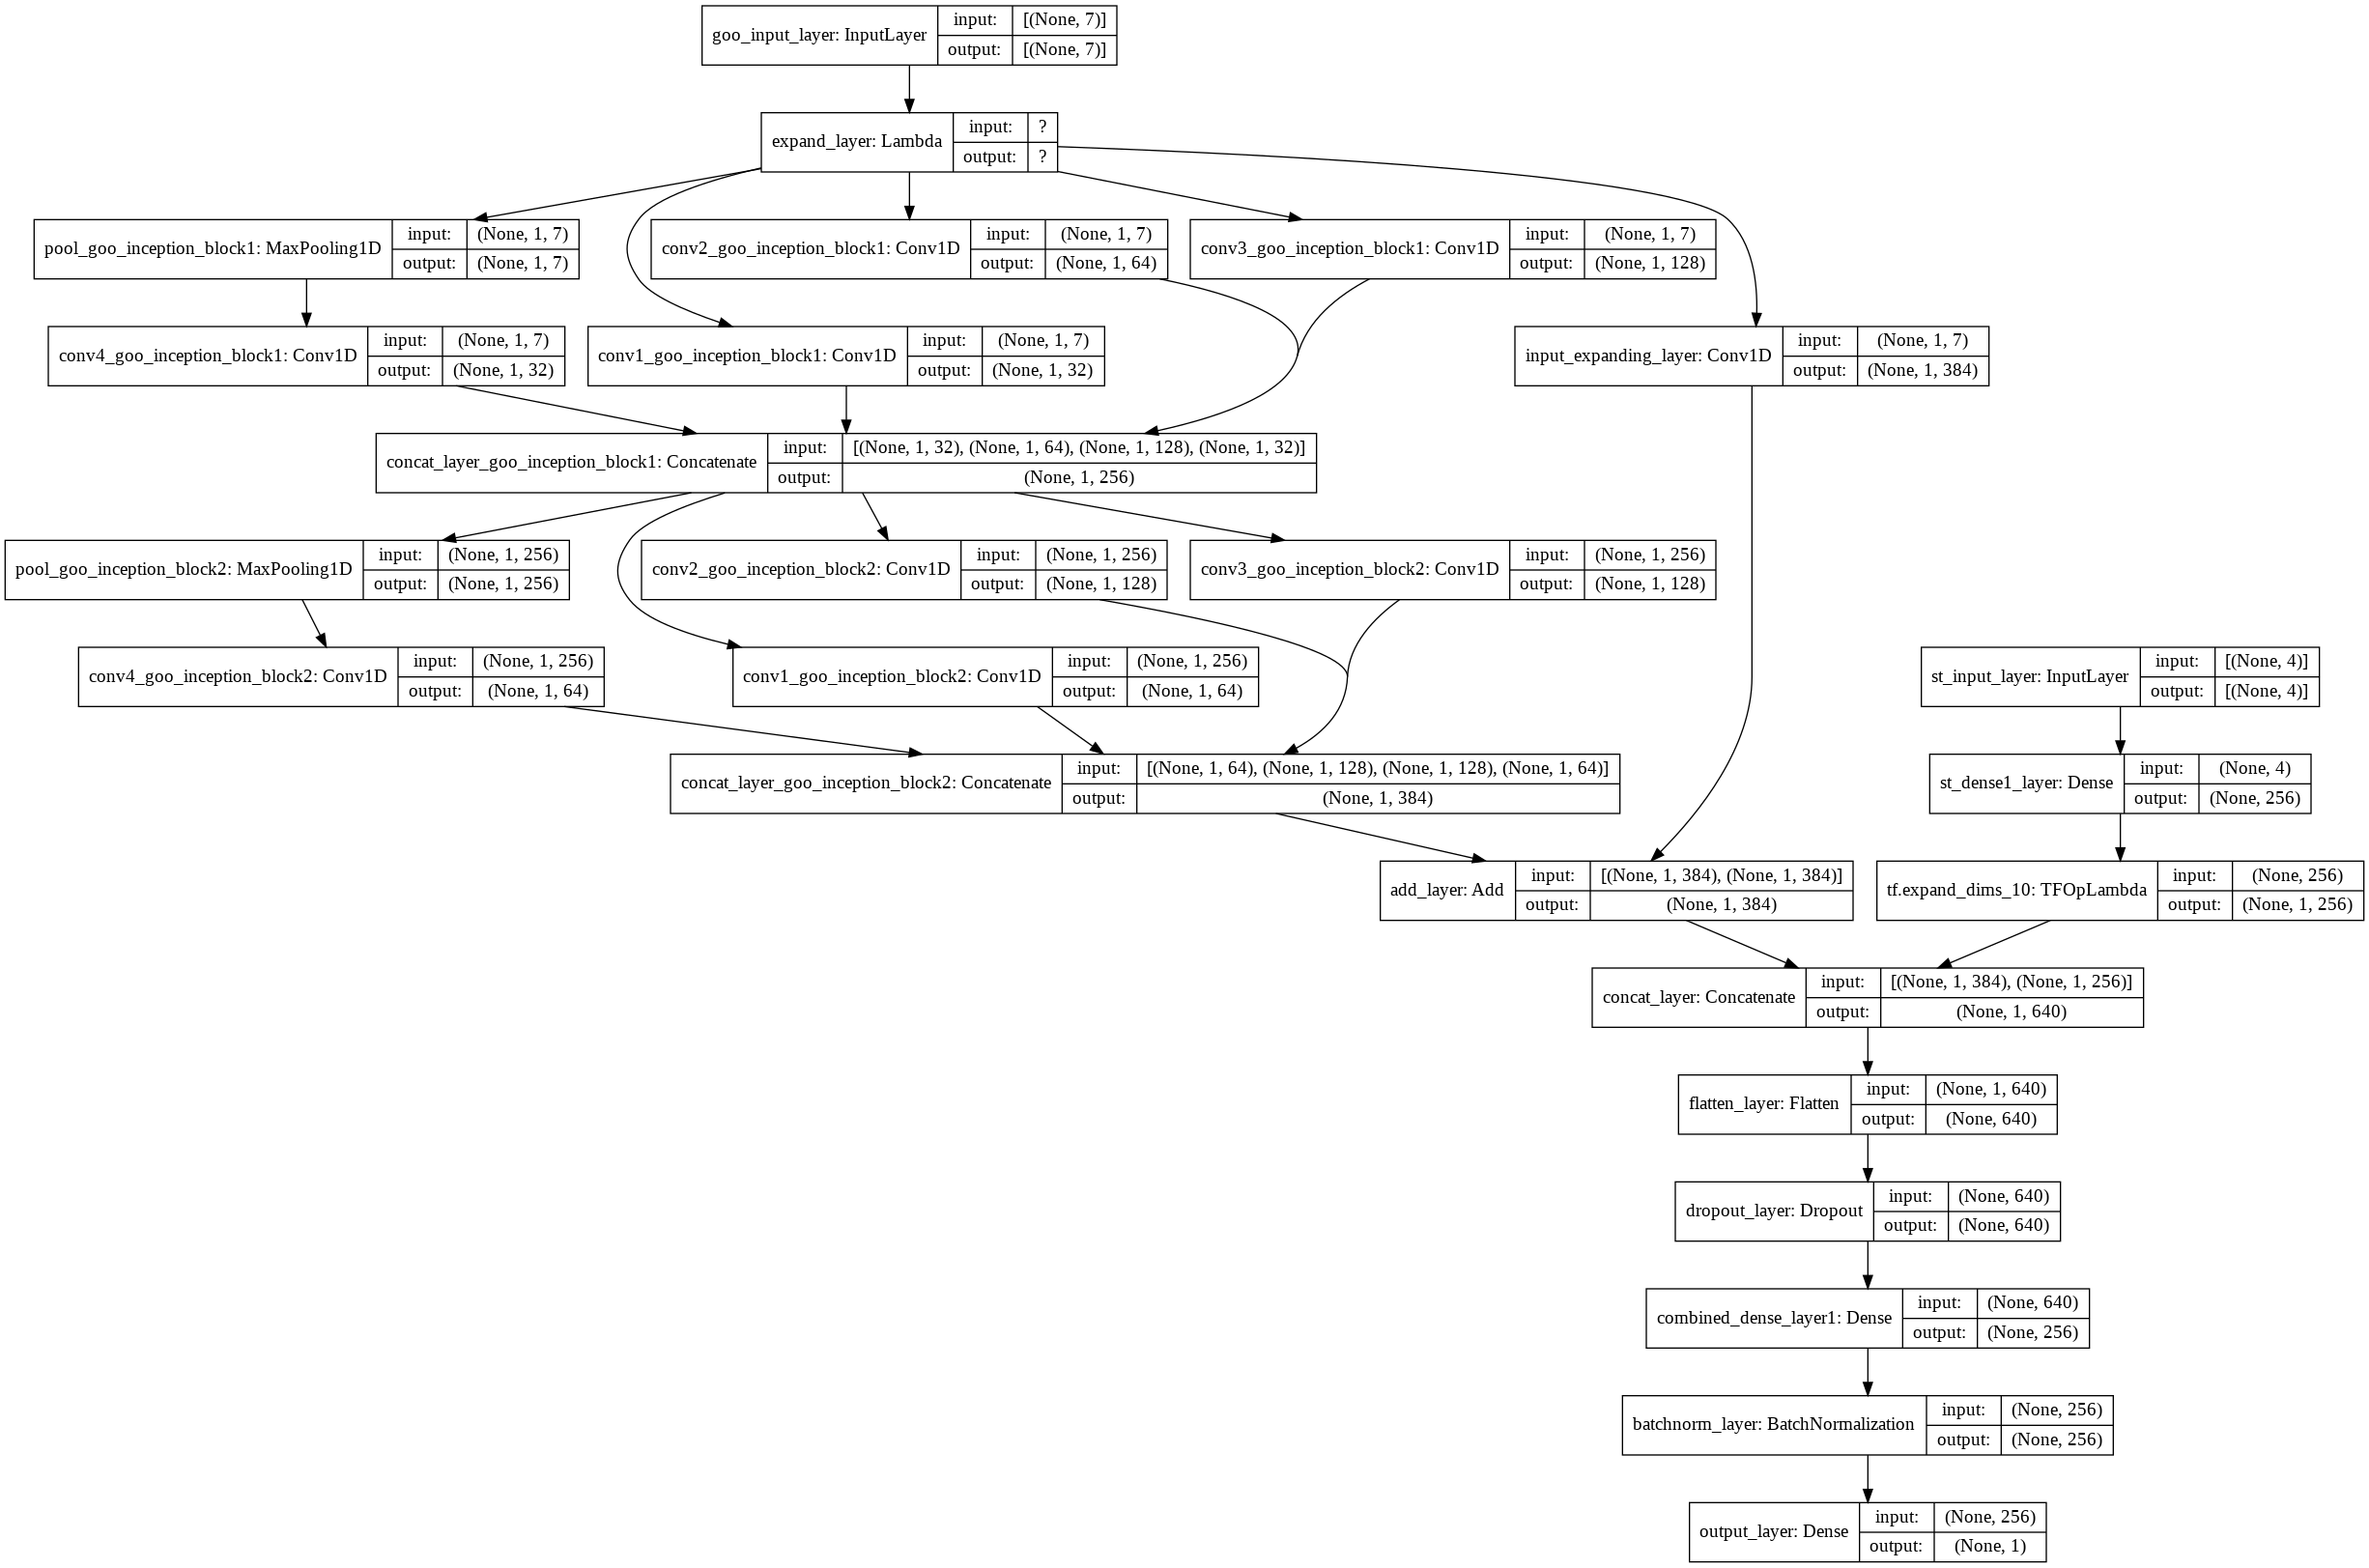

In [ ]:
tf.keras.utils.plot_model(model8, show_shapes=True)

{'mae': 0.52912396, 'rmse': 0.6835262, 'mase': 1.0029892}


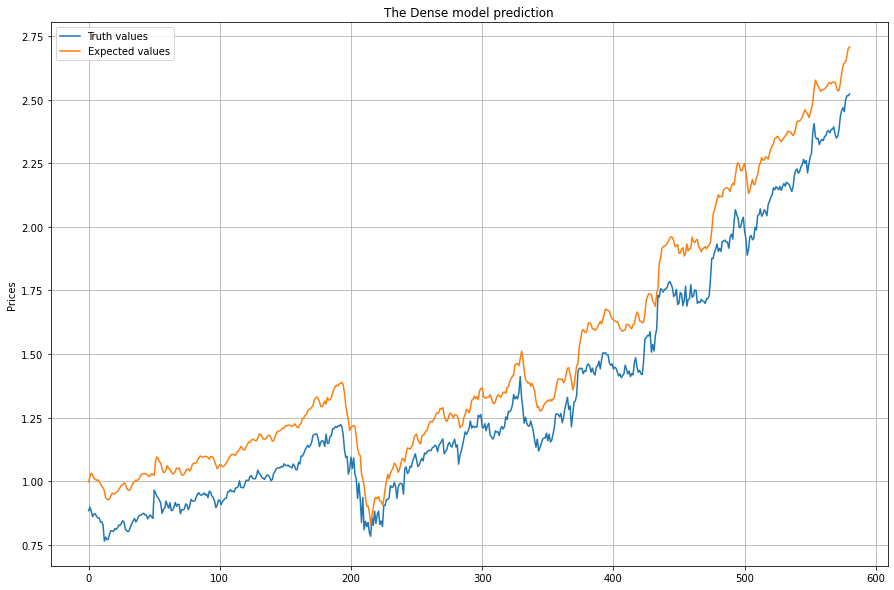

In [ ]:
model8.fit([x_train[:, :7], x_train[:, 7:]], 
           y_train,
           epochs=300,
           batch_size=128,
           verbose=0,
           validation_data=([x_test[:, :7], x_test[:, 7:]], y_test),
           validation_steps=int(0.5 * len(y_test))
           )

y_pred = model8.predict([x_test[:, :7], x_test[:, 7:]])
model8_res = model_results(y_test, y_pred)
print(model8_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

It can be seen that this time model's predictions do not have lags like before. 

It can be tried more complex models(with regularization) or for more epochs